In [1]:
from collections import namedtuple
import glob
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress


from load_data import load_data

## Functions and datatypes
Functions and datatyples that we'll use later on

In [2]:
NeuronData = namedtuple('NeuronData', ['sweep_number', 'spike_times', 'stimulus', 'response', 'rec_times'])

In [3]:
def find_stimulus_start(stimulus, threshold=50):
    diff = stimulus[1:] - stimulus[:-1]
    rises = np.where(diff > threshold)[0]
    if rises.size == 0:
        return None
    return rises[0] + 1

In [4]:
def time_to_offset(times, t):
    where = np.where(times == t)[0]
    if where.size == 0:
        return None
    return where[0]  

In [5]:
def firing_rate(spike_times):
    if spike_times.size < 2:
        return 0

    spike_intervals = spike_times[1:] - spike_times[:-1]
    avg_interval = np.mean(spike_intervals)
    
    return 1/avg_interval

In [6]:
def stimulus_amplitude(stimulus):
    start_of_stimulus_offset = find_stimulus_start(stimulus)
    
    if start_of_stimulus_offset is None:
        return 0
    
    return stimulus[start_of_stimulus_offset]    

In [7]:
def membrane_equlibrium_potential(stimulus, response):    
    return response[50000] # before stimulus

In [31]:
def reset_potential(rec_times, spike_times, response):
    rec_times_to_offset = lambda t: time_to_offset(rec_times, t)
    spike_offsets = list(map(rec_times_to_offset, spike_times))
    
    interspike_interval = response[spike_offsets[0]:spike_offsets[1]]
    
    return np.min(interspike_interval)

## Exercise 1
We'll load and plot the input and response. Since only the [1,2] interval has anything intersting in it, we'll plot its surroundings only.

In [9]:
long_square_39 = NeuronData(*load_data('./l23_aspiny/606517484/long_square_39.mat'))

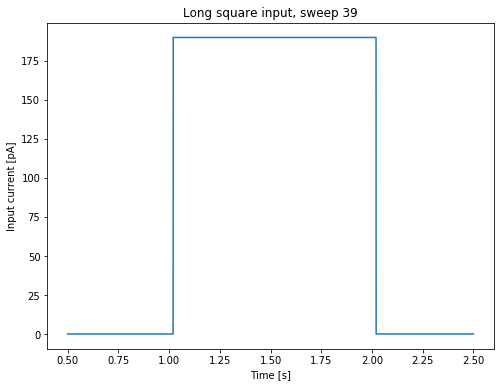

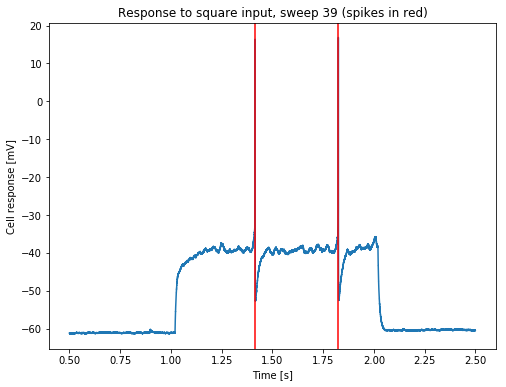

In [73]:
times = (0.5 < long_square_39.rec_times) & (long_square_39.rec_times < 2.5)
plt.figure(figsize=(8,6))
plt.plot(long_square_39.rec_times[times], long_square_39.stimulus[times])
plt.title('Long square input, sweep 39')
plt.xlabel('Time [s]')
plt.ylabel('Input current [pA]')
plt.figure(figsize=(8,6))
plt.plot(long_square_39.rec_times[times], long_square_39.response[times])
for spike in long_square_39.spike_times:
    plt.axvline(spike, color='r')
plt.title('Response to square input, sweep 39 (spikes in red)')
plt.xlabel('Time [s]')
plt.ylabel('Cell response [mV]')
plt.show()

We can see that we're very similar to the graph from the brain atlas. Using this neuron's data, we'll extract the requested parameters:

In [11]:
ls39_firing_rate  = firing_rate(long_square_39.spike_times)
ls39_stimulus_amplitude = stimulus_amplitude(long_square_39.stimulus)
ls39_equib_pot = membrane_equlibrium_potential(long_square_39.stimulus, long_square_39.response)
ls39_reset_pot = reset_potential(long_square_39.rec_times, long_square_39.spike_times, long_square_39.response)

print(f'Neuron firing rate: {ls39_firing_rate:.2f} spikes / s')
print(f'Stimulus amplitude: {ls39_stimulus_amplitude:.2f} pA')
print(f'Membrane equilibrium potential: {ls39_equib_pot:.2f} mV')
print(f'Reset potential: {ls39_reset_pot:.2f} mV')

Neuron firing rate: 2.44 spikes / s
Stimulus amplitude: 190.00 pA
Membrane equilibrium potential: -61.03 mV
Reset potential: -52.72 mV


## Exercise 2

We'll get the firing rates and input amplitudes from all sweeps, then plot the f-I curve

In [12]:
sweeps = sorted(glob.glob('./l23_aspiny/606517484/*'))
firing_rates = np.empty(len(sweeps))
input_amplitudes = np.empty(len(sweeps))
for i, sweep in enumerate(sweeps):
    sweep_data = NeuronData(*load_data(sweep))
    rate = firing_rate(sweep_data.spike_times)
    amplitude = stimulus_amplitude(sweep_data.stimulus)
    firing_rates[i] = rate
    input_amplitudes[i] = amplitude

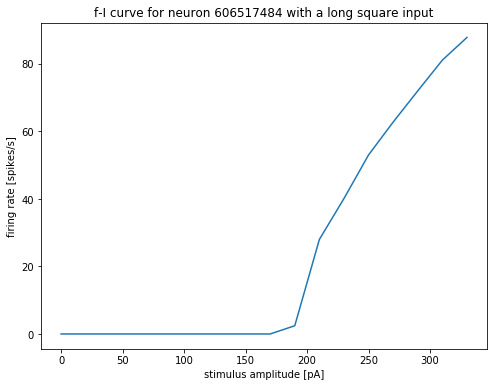

In [74]:
plt.figure(figsize=(8,6))
plt.title('f-I curve for neuron 606517484 with a long square input')
plt.ylabel('firing rate [spikes/s]')
plt.xlabel('stimulus amplitude [pA]')
plt.plot(input_amplitudes, firing_rates)
plt.show()

Here again our results are similar to the ones in the brain atlas. They also make sense - higher amplitudes currents cause increasing fire rates. We can also see the firing rate approaches a line for high stimulus amplitudes.

We'll extract the requested parameters from the curve:

* Extracting $I_{rheo}$:

In [14]:
first_non_zero_rate = np.where(firing_rates > 0)[0][0]
I_rheo = input_amplitudes[first_non_zero_rate]
print(f'I_rheo = {I_rheo:.2f} pA')

I_rheo = 190.00 pA


* Extracting $f_0$ and $b$ for $f_{asymp}$:

In [15]:
largest_currents = input_amplitudes[-4:]
largest_rates = firing_rates[-4:]
b, f0, *_ = linregress(largest_currents, largest_rates)
print(f'f_asymp(I) = {f0:.2f} {b:+0.2f}I')

f_asymp(I) = -50.56 +0.42I


Using these we can calculate the LIF model params:

In [16]:
Veq = ls39_equib_pot # mV
Vreset = ls39_reset_pot # mV
Rm = Veq * b / f0 # mV / pA = Gohm
Vthr = Veq * (f0 + b*I_rheo) / f0 # mV
Tm = Veq / (f0 * (Vthr - Vreset)) # s

In [17]:
print(f'Veq = {Veq:.2f} mV')
print(f'Vreset = {Vreset:.2f} mV')
print(f'Rm = {Rm:.2f} Gohm = {Rm * 1000:.2f} Mohm')
print(f'Vthr = {Vthr:.2f} mv')
print(f'Tm = {Tm:.2f} s = {Tm * 1000: 0.2f} ms')

Veq = -61.03 mV
Vreset = -52.72 mV
Rm = 0.51 Gohm = 509.00 Mohm
Vthr = 35.68 mv
Tm = 0.01 s =  13.66 ms


After using familiar units scales (Mohm and ms), we can see that $\tau_m$ is in the same order of magnitude to what we saw in hw3 (10ms) and what is in the neuron's page in the atlas (11.6ms). Same goes for $V_{eq}$ and $V_{reset}$. 

On the other hand, $V_{thr}$ seems much larger, and with a different sign, than what we saw in hw3. Additionally, the resistence we found is much higher than the one in the atlas (88 in unknown units, presumably Mohms) and the resulting capacitance is:
$$\frac {\tau_m}{R_m} = 0.03pF$$

Which is smaller by ~10x than the one in hw3. However, I don't have any reason to assume a neuron's membrane can't achieve these values for resistance or capacitance.

Overall, these values seem to make sense.

## Exercise 3

In [18]:
def calc_I_rheo(neuron_dir):
    sweeps = sorted(glob.glob(f'{neuron_dir}/*'))
    firing_rates = np.empty(len(sweeps))
    input_amplitudes = np.empty(len(sweeps))
    for i, sweep in enumerate(sweeps):
        sweep_data = NeuronData(*load_data(sweep))
        rate = firing_rate(sweep_data.spike_times)
        amplitude = stimulus_amplitude(sweep_data.stimulus)
        if np.isnan(rate):
            print(sweep, rate, amplitude)
        if rate > 0:
            return amplitude

In [19]:
def calc_Veq(neuron_dir):
    sweeps = glob.glob(f'{neuron_dir}/*')
    many_sweep_data = [ NeuronData(*load_data(sweep)) for sweep in sweeps ]
    many_eq_potential = [ membrane_equlibrium_potential(s.stimulus, s.response) for s in many_sweep_data ]
    return np.mean(many_eq_potential)

In [33]:
def linearize_fi(neuron_dir):
    sweeps = sorted(glob.glob(f'{neuron_dir}/*'))[-4:]
    firing_rates = np.empty(len(sweeps))
    input_amplitudes = np.empty(len(sweeps))
    for i, sweep in enumerate(sweeps):
        sweep_data = NeuronData(*load_data(sweep))
        rate = firing_rate(sweep_data.spike_times)
        amplitude = stimulus_amplitude(sweep_data.stimulus)
        firing_rates[i] = rate
        input_amplitudes[i] = amplitude
    b, f0, *_ = linregress(input_amplitudes, firing_rates)
    
    return b, f0

In [78]:
def calc_tau(neuron_dir, b, f0, Veq, I_rheo):
    sweep = sorted(glob.glob(f'{neuron_dir}/*'))[-1]
    sweep_data = NeuronData(*load_data(sweep))
    Vreset = reset_potential(sweep_data.rec_times, sweep_data.spike_times, sweep_data.response)
    Vthr = Veq * (f0 + b*I_rheo) / f0 # mV
    Tm = Veq / (f0 * (Vthr - Vreset)) # s
    
    return Tm

In [79]:
neurons_data = dict()
for class_dir in glob.glob('l*/'):
    class_name = class_dir.replace('/', '')
    neurons_data[class_name] = dict()
    for neuron_dir in glob.glob(f'{class_dir}/*'):
        neuron_name = os.path.basename(neuron_dir)
        I_rheo = calc_I_rheo(neuron_dir)
        Veq = calc_Veq(neuron_dir)
        b, f0 = linearize_fi(neuron_dir)
        tau = calc_tau(neuron_dir, b, f0, Veq, I_rheo)
        neurons_data[class_name][neuron_name] = dict(I_rheo=I_rheo, Veq=Veq, tau=tau, b=b)

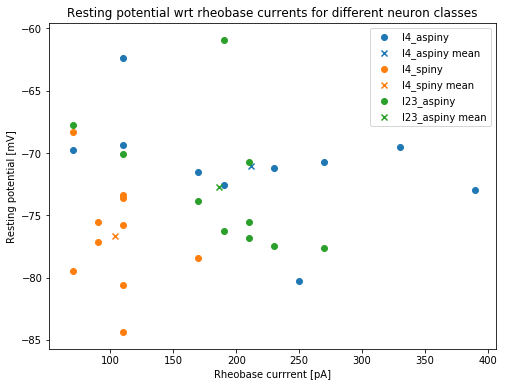

In [80]:
plt.figure(figsize=(8, 6))
plt.xlabel('Rheobase currrent [pA]')
plt.ylabel('Resting potential [mV]')
plt.title('Resting potential wrt rheobase currents for different neuron classes')
for class_name in neurons_data:
    xy = np.array([(x['I_rheo'], x['Veq']) for x in neurons_data[class_name].values()])
    mean = np.mean(xy, axis=0)
    points = plt.scatter(xy[:, 0], xy[:, 1], label=class_name)
    plt.scatter(mean[0], mean[1], color=points.get_edgecolor(), marker='x', label=f'{class_name} mean')

plt.legend()
plt.show()

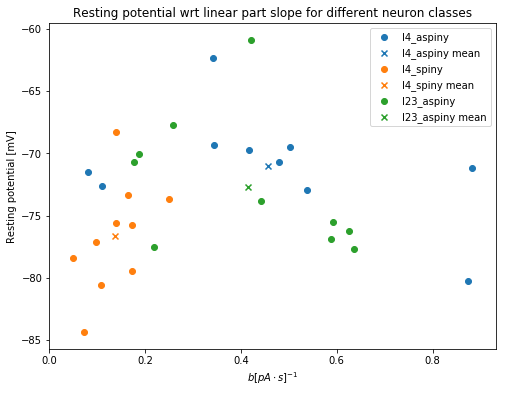

In [85]:
plt.figure(figsize=(8, 6))
plt.xlabel('$b [pA \cdot s]^{-1}$')
plt.ylabel('Resting potential [mV]')
plt.title('Resting potential wrt linear part slope for different neuron classes')
for class_name in neurons_data:
    xy = np.array([(x['b'], x['Veq']) for x in neurons_data[class_name].values()])
    mean = np.mean(xy, axis=0)
    points = plt.scatter(xy[:, 0], xy[:, 1], label=class_name)
    plt.scatter(mean[0], mean[1], color=points.get_edgecolor(), marker='x', label=f'{class_name} mean')
plt.legend()
plt.show()